# CartPole-v1 with REINFORCE

Algorithm 
* http://rll.berkeley.edu/deeprlcoursesp17/docs/lec2.pdf
* https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#reinforce

Gym documentation 
* https://gym.openai.com/docs/
* https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

In [30]:
import gym
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from policy import PolicyApprox, ReinforceLoss, PolicyGradient
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

dim_in = 4 #state [cart position, cart velocity, pole angle, pole velocity at tip]
dim_out = 2 #action space 0/1
hidden = 100
gamma = 1
policy_reinforce = PolicyApprox(dim_in,hidden,dim_out)
reinforce_loss = ReinforceLoss()
optimizer = optim.Adam(params=policy_reinforce.parameters(),lr=1e-2)
env = gym.make('CartPole-v1')

alg = PolicyGradient(policy_reinforce, reinforce_loss, optimizer, {"max_episodes":300,
                                                         "max_timesteps":200,
                                                         "batch_size":1})
losses, episode_length = alg.train(env=env,render=False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


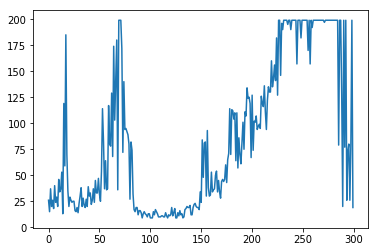

In [32]:
plt.plot(episode_length)

# CartPole-v1 with PPO

In [33]:
from policy import PolicyValueApprox, PPOLoss, ProximalPolicyGradient
%reload_ext autoreload

dim_in = 4 #state [cart position, cart velocity, pole angle, pole velocity at tip]
dim_out = 3 #action space 0/1 + value function
hidden = 150
gamma = 0.99
eps = 0.2
lamb = 0.95
c1 = 10
c2 = 0.01

policy_val = PolicyValueApprox(dim_in, hidden, dim_out)
ppo_loss = PPOLoss(eps, gamma, lamb, c1, c2)
optimizer = optim.Adam(params=policy_val.parameters(),lr=7e-3)
env = gym.make('CartPole-v1')

ppo_alg = ProximalPolicyGradient(policy_val, ppo_loss, optimizer, {"max_episodes":300,
                                                         "max_timesteps":200,
                                                         "batch_size":1})
losses, episode_length = ppo_alg.train(env=env,render=False)

/home/vivi/anaconda3/envs/ml/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


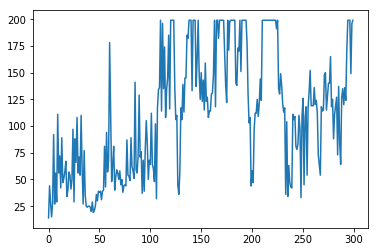

In [34]:
plt.plot(episode_length)